<a href="https://colab.research.google.com/github/GiovaniValdrighi/inferencia_causal/blob/master/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Estudo de variational autoencoder através do texto: https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

Implementação de variational autoencoder com Pyro através do texto: https://pyro.ai/examples/vae.html

#Variational Autoencoder

De modo simples, um **autoencoder** é um método utilizado para diminuir a dimensão de informação. Utilizando de redes neurais criamos duas, um **encoder** e um **decoder**. Seja nossa informação **X** uma matriz de dimensão **(n m)**, o encoder é uma rede neural responsável por transformar **X** para uma dimensão menor, se tornará o que chamamos de **variável latente**, **Z**. Em seguida, o decoder é responsável por transformar **Z** para as dimensões originais, teremos a matriz **X'**. O aprendizado da rede neural ocorre atráves da otimização da distância entre **X** e **X'**. 

No entanto, em um autoencoder simples, o espaço latente não é estável, isto é, valores similhares de **Z** não são similares à **X'**. Para isto, utilizamos de um **variational autoencoder**. A diferença é que transformamos **X** em uma distribuição no espaço latente, e não um valor constante. Assim, para recuperarmos com o decoder, utilizamos de uma amostra aleatória da distribuição do espaço latente, e por consequência do método de treinamento, teremos um decoder que leva amostras aleatórias semlehantes para **X'** semelhantes. Por conveniência, a distribuição do espaço latente é uma Gaussiana, sendo assim,o encoder ao receber **X** retorna a média e a variância da distribuição, geramos uma amostra aleatória de uma normal padrão e por fim repassamos a variável latente para o decoder.

O nosso objetivo é utilizar o banco de dados Deepmind Dsprites que contém um conjunto de figuras 64x64 com 6 características: cor, forma, escala, orientação, posição no eixo X e posição no eixo Y. Geralmente, este banco de dados é utilizado para a verificação de métodos de "desembaraço" (desintanglement), isto é, desejamos avaliar a capacidade das dimensões do espaço latente representarem as características que geraram o banco de dados. Nesta situação, iremos utilizar esse banco de dados para construir uma SCM e realizar perguntas contrafactuais. 

A primeira etapa é a construção de um variational autoencoder simples utilizando o banco de dados. Para lidar com a distribuição, iremos utilizar da biblioteca Pyro. Possuímos duas redes neurais, o encoder e o decoder.

## Encoder
Rede neural resposável por receber um vetor **img** 1x4096 dos pixels de uma figura e um vetor **label** categórico 1x114 contendo as características (cor, forma, escala, orientação, pos. X, pos. Y) da figura. Os dois vetores são concatenados em um vetor **data** 1x4210. Realizamos uma transformação linear que vai do espaço 1x4210 para o espaço 1x1000, criando a variável **hidden**, em seguida, transformamos do espaço 1x1000 para o espaço latente de dimensão 1x200. Geramos duas variáveis latentes utilizando de duas transformações lineares: a **média** (vetor 1x200) e a **variância** (vetor 1x200). 

##Decoder
Rede neural responsável por receber um vetor **latente** 1x200 e um vetor **label** categórico 1x114. Os dois valores são concatenados em um **data** 1x314. Em seguida utilizamos uma transformação linear para o espaço 1x1000 gerando a variável **hidden**. A partir dessa variável, iremos realizar uma transformação linear para o espaço original 1x4210 obtendo a variável **img'**.

##Inferência variancional
O método de inferência que iremos utilizar para as redes neurais utiliza do SVI do Pyro. Para o SVI devemos definir 2 funções estocásticas, o modelo e o guide. O modelo é uma função estocástica de variáveis latentes **z** retornando a imagem **x**. O guide é uma função estocástica da imagem **x** para as variáveis latents **z**.

##Modelo
O modelo é uma função estocástica que recebe a **imagem** 256x4096 e o **label** 256x114, 256 é a dimensão do nosso batch, utilizando o pyro.plate declaramos independência na dimensão do batch. Criamos um vetor média 256x200 e um vetor de variância 256x200 da normal padrão, em seguida geramos uma amostra da variável aleatória **latent** (definida com o pyro), e geramos uma variável aleatória para o label (será explicado depois), e passamos as duas amostras para decoder, que retornará uma matriz 256x4210 sendo a nossa imagem. Por fim, definimos a variável aleatória **loc**, que segue uma distribuição bernoulli com parâmetro igual a **loc** e valor observado igual a **imagem**. 

##Guide
O guide é uma função estocástica que recebe a **imagem** 256x4096 e o **label** 256x114, 256 é a dimensão do nosso batch, utilizando o pyro.plate declaramos independência na dimensão do batch. Geramos uma variável aleatória para o label e passamos para o encoder a imagem e variável aleatória label, obtemos a média e a variância da normal e geramos uma amostra da variável aleatória **latent**.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
!pip3 install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl
!pip3 install torchvision
!pip3 install pyro-ppl

ERROR: torch-0.4.0-{platform}-linux_x86_64.whl is not a valid wheel filename.
     |████████████████████████████████| 430kB 2.7MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyro
import pyro.distributions
import pyro.infer
import pyro.optim
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

As propriedades latentes das imagens são: shape, scale, size, position X e position Y. Vou criar um DAG para inserir relações causais entre as variáveis e em seguida criar um SCM para este DAG.

In [5]:
dataset_zip = np.load('/content/gdrive/My Drive/autoencoder/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle = True, encoding = 'bytes')
print('Keys in the dataset:', dataset_zip.files)
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
latents_sizes = dataset_zip['metadata'][()][b'latents_sizes']
latents_names = dataset_zip['metadata'][()][b'latents_names']

Keys in the dataset: ['metadata', 'imgs', 'latents_classes', 'latents_values']


In [0]:
#function that pick images from the dataset and return the batchs
#with test and training data
def setup_data_loader(images, classes, batch_size = 128, use_CUDA = False):
  #create the dataframes for training and test from the dataset_zip['imgs]
  index = np.random.permutation(imgs.shape[0])
  images = images[index].astype(np.float32)
  classes = classes[index].astype(np.float32)
  train_df = torch.utils.data.TensorDataset(torch.from_numpy(images[100000:].reshape(-1, 4096)), torch.from_numpy(classes[100000:]))
  test_df = torch.utils.data.TensorDataset(torch.from_numpy(images[:100000].reshape(-1, 4096)), torch.from_numpy(classes[:100000]))
  #creates a iterable dataset to train and test, each iteration have batch_size rows of data
  kwargs = {'num_workers': 1, 'pin_memory': use_CUDA}
  train_loader = torch.utils.data.DataLoader(train_df, batch_size, shuffle = False, **kwargs)
  test_loader = torch.utils.data.DataLoader(test_df, batch_size, shuffle = False, **kwargs)
  return train_loader, test_loader

class Encoder(nn.Module):
  '''This class receive the images data as vectors 1x4096
  and the labels of the figure in the image as a 1x114 vector (dummy variables) 
  and should encode it to the latent space as mean and variance of
  a normal distribution

  :param img_dim: dimension of image vector
  :param label_dim: dimension of label vector
  :param latent_dim: dimension of latent space, output
  '''
  def __init__(self, img_dim = 4096, label_dim = 114, latent_dim = 200):
    super(Encoder, self).__init__()
    self.img_dim = img_dim
    self.label_dim = label_dim
    self.latent_dim = latent_dim 
    #linear transformations used
    self.fc1 = nn.Linear(img_dim + label_dim, 1000)
    self.fc21 = nn.Linear(1000, latent_dim)
    self.fc22 = nn.Linear(1000, latent_dim)
    #non-linear transformation used
    self.softplus = nn.Softplus()

  def forward(self, img, label):
    #use the transformation to get the hidden variable
    data = torch.cat((img, label), -1)
    hidden = self.softplus(self.fc1(data))
    #use the transformation to get the mean and the variance
    mean_z = self.fc21(hidden)
    cov_z = torch.exp(self.fc22(hidden))
    return mean_z, cov_z


class Decoder(nn.Module):
  '''This class receive a sample of the latent variable
  and return the image as a data vector 1x4096 and
  the latent classes as a vector 1x5

  :param img_dim: dimension of image vector
  :param label_dim: dimension of label vector
  :param latent_dim: dimension of latent space, output
  '''
  def __init__(self, img_dim = 4096, label_dim = 114, latent_dim = 200):
    super(Decoder, self).__init__()
    self.img_dim = img_dim
    self.label_dim = label_dim
    self.latent_dim = latent_dim
    #linear transformations used
    self.fc1 = nn.Linear(latent_dim+label_dim, 1000)
    self.fc2 = nn.Linear(1000, img_dim)
    #non-linear transformations used
    self.softplus = nn.Softplus()
    self.sigmoid = nn.Sigmoid()

  def forward(self, latent, label):
    #use the transformation to get the hidden variable
    data = torch.cat((latent, label), -1)
    hidden = self.softplus(self.fc1(data))
    #use the transformation to get the image
    image = self.sigmoid(self.fc2(hidden))
    return image

class VAE(nn.Module):
  '''
  This class define the p(z|x) and the p(x|z)
  and use the scm model to call the encoder and
  decoder

  
  :param img_dim: dimension of image vector
  :param label_dim: dimension of label vector
  :param latent_dim: dimension of latent space, output
  '''
  def __init__(self, latents_sizes, latents_names, img_dim = 4096, label_dim = 114, latent_dim = 200, use_CUDA = False):
    super(VAE, self).__init__()
    #creating networks
    self.encoder = Encoder(img_dim, label_dim, latent_dim)
    self.decoder = Decoder(img_dim, label_dim, latent_dim)
    self.img_dim = img_dim
    self.label_dim = label_dim
    self.latent_dim = latent_dim
    self.latents_sizes = latents_sizes
    self.latents_names = latents_names
    if use_CUDA:
      print('Ativei o self.cuda()')
      self.cuda()
    self.use_CUDA = use_CUDA
  
  def label_variable(self, label):
    new_label = []
    options = {'device': label.device, 'dtype': label.dtype}
    for i, length in enumerate(self.latents_sizes):
      prior = torch.ones(label.shape[0], length, **options) / (1.0 *length)
      new_label.append(pyro.sample("label_" + str(self.latents_names[i]), 
                      pyro.distributions.OneHotCategorical(prior), 
                      obs = torch.nn.functional.one_hot(torch.tensor(label[:, i], dtype = torch.int64), int(length))))
    new_label = torch.cat(new_label, -1)
    return new_label.to(torch.float32).to(label.device)

  def model(self, img, label):
    '''
    Function in the VAE that defines
    p(x|z)
    '''
    pyro.module("decoder", self.decoder)
    options = {'device': img.device, 'dtype': img.dtype}
    with pyro.plate("data", img.shape[0]):
      z_mean = torch.zeros(img.shape[0], self.latent_dim, **options)
      z_variance = torch.ones(img.shape[0], self.latent_dim, **options)
      z_sample = pyro.sample("latent", pyro.distributions.Normal(z_mean, z_variance).to_event(1))
      image = self.decoder.forward(z_sample, self.label_variable(label))
      pyro.sample("obs", pyro.distributions.Bernoulli(image).to_event(1), obs = img)


  def guide(self, img, label):
    '''
    Function that is the guide to the model
    shape, scale, orientation, posX, posY = g(img)
    the p(z|x) use on the encoder
    '''
    pyro.module("encoder", self.encoder)
    with pyro.plate("data", img.shape[0]):
      z_mean, z_variance = self.encoder.forward(img, self.label_variable(label))
      pyro.sample("latent", pyro.distributions.Normal(z_mean, z_variance).to_event(1))


In [0]:
pyro.enable_validation(True)
pyro.clear_param_store()
#the training routine
use_CUDA = False
train_loader, test_loader = setup_data_loader(imgs, latents_classes, use_CUDA = use_CUDA)
vae = VAE(latents_sizes, latents_names, use_CUDA = use_CUDA)

In [8]:
vae.load_state_dict(torch.load('/content/gdrive/My Drive/trained_movel_epoch_24.save'))

<All keys matched successfully>

## Código abaixo deve ser rodado apenas em caso de treinamento do variational autoencoder.

In [0]:

#optimizer
optimizer = pyro.optim.Adam({"lr" : 1.0e-3})

#inference algorithm
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(vae.model, vae.guide, optimizer, elbo)

train_elbo = []
test_elbo = []
num_epochs = 70
test_freq = 8
for epoch in tqdm(range(num_epochs)):
  epoch_loss = 0.
  for (img, label) in train_loader:
    if use_CUDA:
      print('check')
      img = img.cuda()
      label = label.to(img.device)
    epoch_loss += svi.step(img, label)
  total_epoch_loss_train = epoch_loss/len(train_loader)
  train_elbo.append(total_epoch_loss_train)
  print("epoch: " + str(epoch) + " average training loss: " + str(epoch_loss))

  if epoch % test_freq == 0:
    test_loss = 0
    for (img, label) in test_loader:
      if use_CUDA:
        print('check2')
        img = img.cuda()
        label = label.to(img.device)
      test_loss += svi.evaluate_loss(img, label)
    total_epoch_loss_test  = epoch_loss/len(test_loader)
    test_elbo.append(total_epoch_loss_test)
    torch.save(vae.state_dict(), '/content/gdrive/My Drive/trained_movel_epoch_'+ str(epoch) + '.save')

In [0]:
def dummy_from_label(label):
  sizes = [1, 3, 6, 40, 32, 32]
  dummy = []
  for i, length in enumerate(sizes):
    dummy.append(torch.nn.functional.one_hot(torch.tensor(label[:, i], dtype = torch.int64), int(length)))
  return torch.cat(dummy, -1).to(torch.float32)

def run_img_vae(img, label, num = 1):
  label = label.reshape(1, -6)
  dummy_label = dummy_from_label(label)
  img = torch.tensor(img.reshape(-1, 4096)).to(torch.float32)
  mean, var = vae.encoder.forward(img, dummy_label)

  fig = plt.figure(figsize = (4, num*5))
  plots = []
  plots.append(plt.subplot(num+1, 1, 1))
  plots[0].set_title('Original image')
  plt.imshow(img.reshape(64, 64))
  
  for i in range(1, num):
    z_sample = pyro.distributions.Normal(mean, var).sample()
    vae_img = vae.decoder.forward(z_sample, dummy_label)
    plots.append(plt.subplot(num+1, 1, i+1))
    plots[-1].set_title(str(i) +' - sample of latent space')
    plt.imshow(vae_img.detach().numpy().reshape(64, 64))
  plt.show()

def change_attribute(img, label, attribute = 1):
  print('Attribute changed was ' + str(latents_names[attribute]))
  label = label.reshape(1, -6)
  new_label = label2 = np.copy(label)
  k = np.random.choice(list(range(latents_sizes[attribute]))) 
  new_label[0, attribute] = k if new_label[0, attribute] != k else k + 1.0
  new_label[0, attribute] = new_label[0, attribute] if new_label[0, attribute] <= latents_sizes[attribute] else new_label[0, attribute] - 2.0 
  dummy_label = dummy_from_label(label)
  new_dummy = dummy_from_label(new_label)
  img = torch.tensor(img.reshape(-1, 4096)).to(torch.float32)
  mean, var = vae.encoder.forward(img, dummy_label)
  
  fig = plt.figure(figsize = (4, 15))
  plots = []
  plots.append(plt.subplot(3, 1, 1))
  plots[0].set_title('Original image')
  plt.imshow(img.reshape(64, 64))
  z_sample = pyro.distributions.Normal(mean, var).sample()
  vae_img = vae.decoder.forward(z_sample, dummy_label)
  plots.append(plt.subplot(3, 1, 2))
  plots[1].set_title('Sample with original attribute')
  plt.imshow(vae_img.detach().numpy().reshape(64, 64))
  z_sample = pyro.distributions.Normal(mean, var).sample()
  vae_img = vae.decoder.forward(z_sample, new_dummy)
  plots.append(plt.subplot(3, 1, 3))
  plots[2].set_title('Sample with changed attribute')
  plt.imshow(vae_img.detach().numpy().reshape(64, 64))
  plt.show()


def ind_from_att(color, shape, scale, orientation, posX, posY):
  return (color - 1)*3*6*40*32*32 + (shape - 1)*6*40*32*32 + (scale -1)*40*32*32 + (orientation - 1)*32*32 + (posX - 1)*32 + posY 

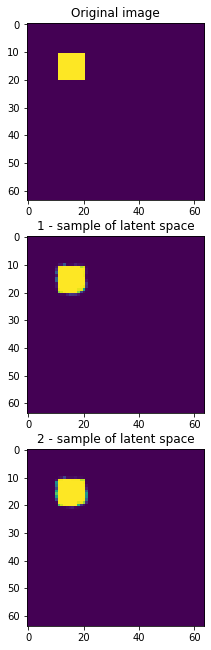

In [10]:
run_img_vae(imgs[0], latents_classes[0], num = 3)

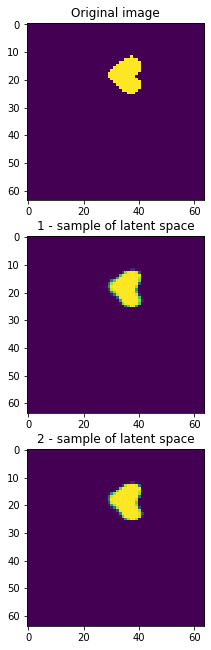

In [11]:
ind = np.random.randint(imgs.shape[0])
run_img_vae(imgs[ind], latents_classes[ind], num = 3)

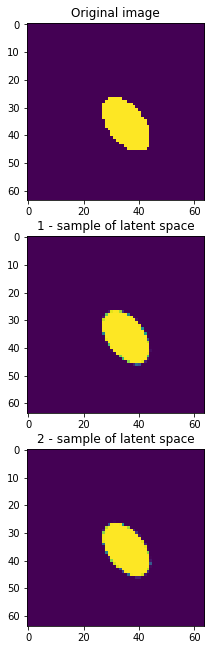

In [12]:
run_img_vae(imgs[ind_from_att(1, 2, 5, 15, 20, 20)], latents_classes[ind_from_att(1, 2, 5, 15, 20, 20)], num = 3)

Attribute changed was b'shape'


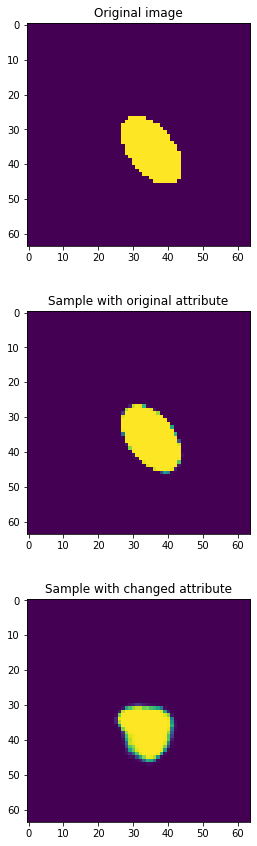

In [13]:
change_attribute(imgs[ind_from_att(1, 2, 5, 15, 20, 20)], latents_classes[ind_from_att(1, 2, 5, 15, 20, 20)])

Attribute changed was b'orientation'


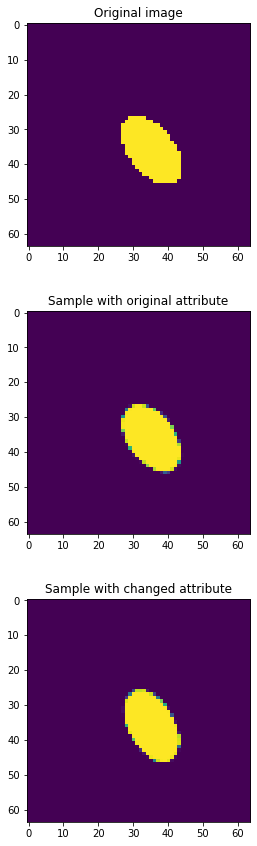

In [14]:
change_attribute(imgs[ind_from_att(1, 2, 5, 15, 20, 20)], latents_classes[ind_from_att(1, 2, 5, 15, 20, 20)], attribute = 3)

## Model
The model is the generative process of the images. I invented a causal story that relates the variables: shape, scale, orientation, pos X, pos Y, image.
Every variable has a noise, that will be uniform and is a function of other variables, the variables that cause it. The image is a function of the variables, they are the cause, and that function will be represented by our decoder, where it generates the image from the latent sample and the labels.

__Noises:__ We will set a uniform with the dimensions of the dummy variable of the corresponding variable. For exemple, the variable shape has the form [0, 0, 1] so We will set a uniform of dimension 3 in the interval [0, 1] for each dimension.

Our noise variables are:
- N_color ~ U[0,1] dim 1
- N_shape ~ U[0,1] dim 3
- N_scale ~ U[0,1] dim 6
- N_orien ~ U[0,1] dim 40
- N_posX ~ U[0,1] dim 32
- N_posY ~ U[0,1] dim 32
- N_latent ~ U[0,1] dim 200
- N_img ~ U[0,1] dim 4096


In [0]:
def f_shape(N_shape):
  return torch.tensor([0.3, 0.35, 0.35])

def f_scale(N_scale):
  return torch.tensor([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])

def f_orien(shape, scale, N_orien):
  pass
  
def f_X(N_x):
  pass

def f_Y(N_y):
  pass

  
def model(noise):

  #Noise variables
  N_shape = pyro.sample('N_shape', noise['shape'].to_event(1))
  N_scale = pyro.sample('N_scale', noise['scale'].to_event(1))
  N_orien = pyro.sample('N_orien', noise['orien'].to_event(1))
  N_posX = pyro.sample('N_posX', noise['posX'].to_event(1))
  N_posY = pyro.sample('N_posY', noise['posY'].to_event(1))
  N_latent = pyro.sample('N_latent', noise['latent'].to_event(1))
  N_img = pyro.sample('N_img', noise['img'].to_event(1))

  color = pyro.sample('color', pyro.distributions.OneHotCategorial(torch.tensor([1.])))
  shape = pyro.sample('shape', pyro.distributions.OneHotCategorical(f_shape(N_shape)))
  scale = pyro.sample('scale', pyro.distributions.OneHotCategorical(f_scale(N_scale)))
  orien = pyro.sample('orien', pyro.distributions.OneHotCategorical(shape, scale, f_orien(N_orien)))
  X = pyro.sample('x', pyro.distributions.OneHotCategorical(f_X(N_X)))
  Y = pyro.sample('y', pyro.distributions.OneHotCategorical(f_Y(N_Y)))

  label = torch.cat([color, shape, scale, orien, X, Y], -1)

  return label
gaussian_noise = { 'color' : pyro.distributions.Uniform(torch.zeros(latents_sizes[0]), torch.ones(latents_sizes[0])),
                  'shape' : pyro.distributions.Uniform(torch.zeros(latents_sizes[1]), torch.ones(latents_sizes[1])),
                  'scale' : pyro.distributions.Uniform(torch.zeros(latents_sizes[2]), torch.ones(latents_sizes[2])),
                  'orien' : pyro.distributions.Uniform(torch.zeros(latents_sizes[3]), torch.ones(latents_sizes[3])),
                  'posX' : pyro.distributions.Uniform(torch.zeros(latents_sizes[4]), torch.ones(latents_sizes[4])),
                  'posY' : pyro.distributions.Uniform(torch.zeros(latents_sizes[5]), torch.ones(latents_sizes[5])),
                  'latent' : pyro.distributions.Uniform(torch.zeros(200.), torch.ones(200.)),
                  'img' : pyro.distributions.Uniform(torch.zeros(4096), torch.ones(4096.))}



In [16]:
latents_sizes

array([ 1,  3,  6, 40, 32, 32])

In [17]:
pyro.distributions.Uniform(torch.zeros(latents_sizes[3]), torch.ones(latents_sizes[3])).sample()

tensor([0.3303, 0.4932, 0.8302, 0.3119, 0.1133, 0.7690, 0.4958, 0.0970, 0.9162,
        0.7469, 0.0945, 0.0533, 0.6847, 0.1222, 0.5347, 0.4669, 0.3000, 0.6021,
        0.0634, 0.2305, 0.3742, 0.5437, 0.0918, 0.2228, 0.0804, 0.6566, 0.9870,
        0.8001, 0.4613, 0.8560, 0.5461, 0.4195, 0.8057, 0.2922, 0.6134, 0.5162,
        0.1206, 0.9437, 0.0773, 0.9798])

In [18]:
latents_names

(b'color', b'shape', b'scale', b'orientation', b'posX', b'posY')